In [84]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# helpful tools
from mc_tools import *

In [109]:
# Import packages
import cvxpy as cp
import numpy as np
import random

def _cp_solver(M, omega):
    """
    M is our original (square) matrix
    Omega is our set
    """
    r, c = M.shape
    W1 = cp.Variable((r,r))
    X = cp.Variable((r,c))
    # X.T = (c,r)
    W2 = cp.Variable((c,c))

    objective = cp.Minimize(cp.trace(W1)+cp.trace(W2))
    constraints = [cp.vstack((cp.hstack((W1,X)),cp.hstack((X.T, W2)))) >> 0]
    for i,j in omega:
        if (M[i,j] != 0):
            constraints.append(X[i, j] == M[i, j]) 
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value

def generate_omega(r, c, m):
    """ 
    sample m data points from (r x c) matrix
    """
    return random.sample([(i, j) for i in range(r) for j in range(c)], m)

def mask_image(image, p=0, omega=None):
    """ 
    blurs and image
    """
    r,c = image.shape
    if omega is None:
        m = r*c*(1-p)
        omega = generate_omega(r,c, int(m))

    # # TODO : simplify?
    mask = np.zeros((r,c ))
    for i, j in omega:
        mask[i, j] = 1
    
    return mask * image

def mc_solver(image, m=None, omega=None):
    '''
    takes in an (masked) image 
    and m = size of omega
    '''
    if m is None:
        # TODO: change this to be theoretical value of good omega
        m = 0
    r,c = image.shape
    if omega is None:
        omega = generate_omega(r,c, m)
    return _cp_solver(image, omega)

In [86]:
fashion_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

fashionData = fashion_data.data.numpy()

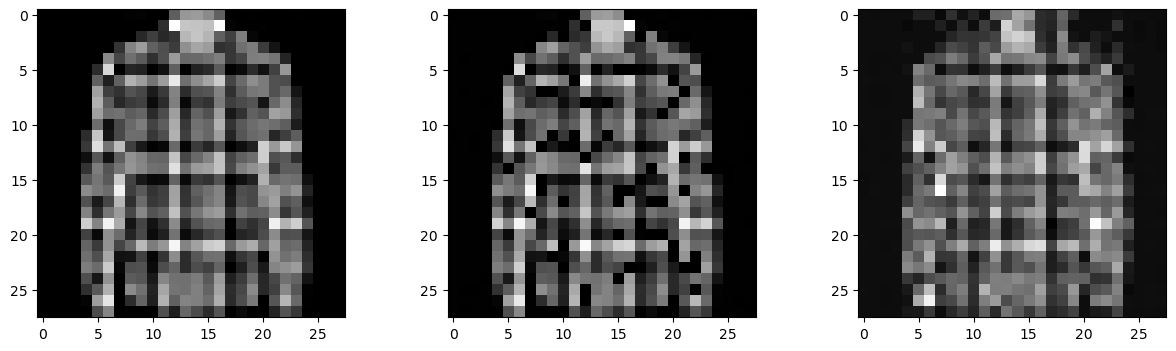

<Figure size 1000x1000 with 0 Axes>

In [107]:
# images are 28 x 28
r, c = 28, 28
# percent of points to remove   # TODO: Very arbitrary
p = .1
# TODO: Very arbitrary 
m = 400

# pick a random image in fashionData
sample = np.random.randint(0,fashionData.shape[1])
# mask it
masked_image = mask_image(fashionData[sample]+1, p)
# # try to unmask it with sdp
im = mc_solver(masked_image, m)-1

# plot both images

rows, cols = 1, 3
fig, axs = plt.subplots(rows,cols, figsize=(5*cols,4*rows))
figure = plt.figure(figsize=(10, 10))
# fig.suptitle("original mask unmaked")
axs[0].imshow(fashionData[sample], cmap="gray")
axs[1].imshow(masked_image, cmap="gray")
axs[2].imshow(im,cmap="gray")
plt.show()

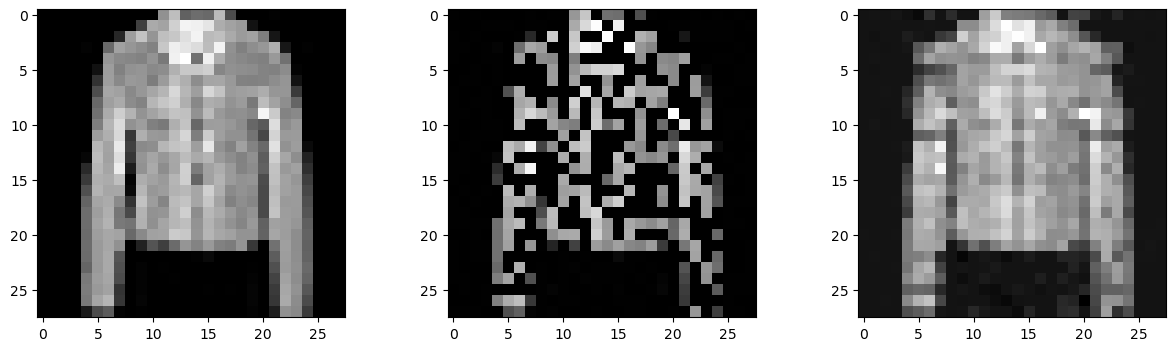

<Figure size 1000x1000 with 0 Axes>

In [110]:
# images are 28 x 28
r, c = 28, 28
# percent of points to remove   # TODO: Very arbitrary
p = .1
# TODO: Very arbitrary 
m = 400

# pick a random image in fashionData
sample = np.random.randint(0,fashionData.shape[1])
# sample some data points
omega = generate_omega(r,c, int(m))
# mask it
masked_image = mask_image(fashionData[sample]+1, omega=omega)
# # try to unmask it with sdp
im = mc_solver(masked_image, m, omega=omega)-1

# plot both images

rows, cols = 1, 3
fig, axs = plt.subplots(rows,cols, figsize=(5*cols,4*rows))
figure = plt.figure(figsize=(10, 10))
# fig.suptitle("original mask unmaked")
axs[0].imshow(fashionData[sample], cmap="gray")
axs[1].imshow(masked_image, cmap="gray")
axs[2].imshow(im,cmap="gray")
plt.show()